In [ ]:
import numpy as np
import math
import re
import scipy
import statsmodels as sm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

In [ ]:
from __future__ import print_function

import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf   # deprecated. need updated version
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

Instructions for updating:
non-resource variables are not supported in the long term


# Process testing data （ignore this）

In [ ]:
dt_test = pd.read_csv('C:/Users/RegenwetterLab/CS412/DATA/qualifying.txt', header = None, names = ['user_id', 'date'], usecols = [0,1])

In [ ]:
dt_test.info()
print(dt_test.head())
print(dt_test.tail())

Preprocess testing data by extracting movies and adding a new column "movie_id"

In [ ]:
movies_test = dt_test[dt_test['date'].isna()]['user_id']
movies_test = movies_test.str.strip(':')
movies_test = movies_test.to_frame().reset_index()
movies_test.columns = ['dt_test_index', 'movie_id']
movies_test.head(n=10)

In [ ]:
movies_test.info()

In [ ]:
users_test = []
mid = movies_test['movie_id']
k = 0
for idx1,idx2 in zip(movies_test['dt_test_index'][0:], movies_test['dt_test_index'][1:]):
    temp = dt_test.loc[idx1+1:idx2-1].copy()
    temp['movie_id'] = mid[k]
    users_test.append(temp)
    k = k+1

In [ ]:
# last movie
last_idx = movies_test.iloc[-1,0]
last_movie = movies_test.iloc[-1,1]
last_recod = dt_test.loc[last_idx+1:].copy()
last_recod['movie_id'] = last_movie
users_test.append(last_recod)

In [ ]:
df_test = pd.concat(users_test)
df_test.info()
print(df_test.head())
print(df_test.tail())

In [ ]:
# reset index
df_test = df_test.reset_index(drop=True)
df_test.info()

# Subsample filtered dataset

In [ ]:
dt_filtered = pd.read_csv('C:/Users/RegenwetterLab/CS412/filtered_data.txt')

In [ ]:
dt_filtered = dt_filtered.iloc[:, 1:]

In [ ]:
dt_filtered.info()
print(dt_filtered.head())
print(dt_filtered.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95726056 entries, 0 to 95726055
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   rating    float64
 2   movie_id  int64  
dtypes: float64(1), int64(2)
memory usage: 2.1 GB
   user_id  rating  movie_id
0  1488844   3.000         1
1   822109   5.000         1
2   885013   4.000         1
3    30878   4.000         1
4   823519   3.000         1
          user_id  rating  movie_id
95726051  1790158   4.000     17770
95726052  1608708   3.000     17770
95726053   234275   1.000     17770
95726054   255278   4.000     17770
95726055   453585   2.000     17770


In [ ]:
users = dt_filtered['user_id'].unique()

In [ ]:
users.shape

(324471,)

In [ ]:
users_sampled = np.random.choice(users, size = int(users.shape[0]*0.25), replace = False)

In [ ]:
users_sampled.shape

(81117,)

In [ ]:
dt_sampled = dt_filtered[dt_filtered['user_id'].isin(users_sampled)]

In [ ]:
dt_sampled['user_id'].value_counts()

2439493    12506
1314869     8210
1461435     7935
491531      6436
1663888     6193
           ...  
1178518       42
1501724       41
1324947       40
531787        37
1110918       34
Name: user_id, Length: 81117, dtype: int64

In [ ]:
dt_sampled['user_id'].max()

2649429

In [ ]:
dt_sampled['movie_id'].max()

17770

In [ ]:
# delete objects no longer needed to save memory
del dt_filtered

In [ ]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [ ]:
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[dt_sampled['user_id'].max()+1, dt_sampled['movie_id'].max()+1])

In [ ]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

In [ ]:
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [ ]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

In [ ]:
# Build the CF model and train it.
model = build_model(dt_sampled, embedding_dim=20, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

In [ ]:
model.train(num_iterations = 500, learning_rate = 20.)

In [ ]:
model.train(num_iterations = 500, learning_rate = 20.)

 iteration 1000: train_error=1.022531, test_error=1.0622330

[{'train_error': 1.0225307, 'test_error': 1.0622331}]

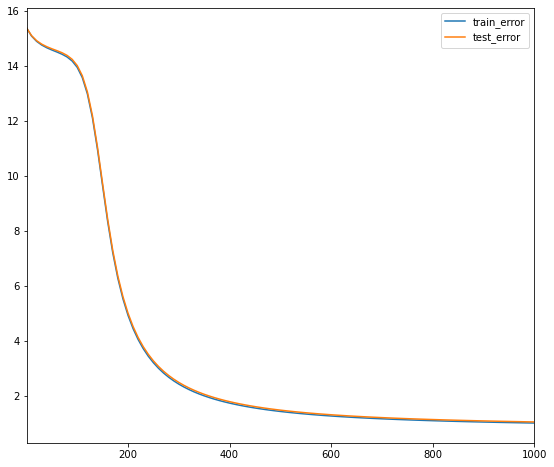

In [ ]:
# build and train another model based on tuned hyperparameters using a smaller dataset
model2 = build_model(dt_sampled, embedding_dim=20, init_stddev=0.5)
model2.train(num_iterations=1000, learning_rate=50.)

In [ ]:
user_embeddings = model2.embeddings['user_id']
np.save('user_embeddings', user_embeddings)

In [ ]:
movie_embeddings = model2.embeddings['movie_id']
np.save('movie_embeddings', movie_embeddings)

In [ ]:
dt_sampled.to_csv('sampled_data_25perc_users.txt')